# Import modules

In [1]:
# geo-data handling
import xarray as xr

# standard numerical package
import numpy as np

# visualization
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

# Load data

(These cells are not needed if you have land_mask.png)

In [2]:
lm_files = ['b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.LANDFRAC.201501-206412.nc',
            'b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.LANDFRAC.206501-209912.nc']

files = {'Control': lm_files}

In [3]:
scenarios = ['Control']
lm1 = {}

for scenario in scenarios:
    # collect all partial datasets
    da_container = []
    for file_name in files[scenario]:
        path = f"./data/{scenario}/{file_name}"
        da_container.append(xr.open_dataset(path).LANDFRAC)
    # concatenate the dataset
    lm1[scenario] = xr.concat(da_container,dim='time')
    
# change 0 to nan
land_mask = lm1['Control'].where(lm1['Control'].data == 1, np.nan) 

### Temperature

In [4]:
T_cnt_files = ['b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.TREFHT.201501-206412.nc',
            'b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.TREFHT.206501-209912.nc']

# due to an error that occured during the simulation, the years 2045-2050 are faulty in the first run.
# one has to manually crop them
T_sai2020_files = ['b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.TREFHT.202001-202912.nc',
                'b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.TREFHT.203001-203912.nc',
                'b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.TREFHT.204001-204912.nc',
                'b.e21.BSSP585cmip6.f09_g17.2020feedback.02.cam.h0.TREFHT.204501-209412.nc',
                'b.e21.BSSP585cmip6.f09_g17.2020feedback.02.cam.h0.TREFHT.209501-209912.nc']

T_sai2080_files = ['b.e21.BSSP585cmip6.f09_g17.feedback.05.cam.h0.TREFHT.208001-208512.nc',
                'b.e21.BSSP585cmip6.f09_g17.feedback.06.cam.h0.TREFHT.208601-209912.nc']

files = {
    'Control': T_cnt_files,
    'SAI 2020': T_sai2020_files,
    'SAI 2080': T_sai2080_files
}

In [5]:
# save the temperature data in dictionaries indexed by the scenario name
scenarios = ['Control', 'SAI 2020', 'SAI 2080']
T1 = {}

for scenario in scenarios:
    # collect all partial datasets
    da_container = []
    for file_name in files[scenario]:
        path = f"./data/{scenario}/{file_name}"
        # handle the special case of SAI2020
        if (scenario == 'SAI 2020') and (file_name == T_sai2020_files[2]):
            da_container.append(xr.open_dataset(path).TREFHT.sel(time=slice('2040','2044')))
        else:
            da_container.append(xr.open_dataset(path).TREFHT)
    # concatenate the dataset
    T1[scenario] = xr.concat(da_container,dim='time')

In [6]:
# without land mask
T = {'Control': T1['Control'].sel(time = slice('2020', '2099')) - 273.15,
     'SAI 2020': T1['SAI 2020'].sel(time = slice('2020', '2099')) - 273.15,
     'SAI 2080': xr.concat((T1['Control'].sel(time = slice('2020', '2079')), T1['SAI 2080'].sel(time = slice('2080', '2099'))), dim = 'time') - 273.15}

# Functions

In [7]:
def get_coords(var, num):
    
    """
    Gets the coordenates of the studied line
    
    Parameters:
        var (matplotlib.contour): line in the contour plot
        num (integer): number that represents which line we are looking at (SH or NH)

    Returns: 
        Array with two lists containing the coordenates for x and y  
    """
    
    x = var.collections[0].get_paths()[num].vertices[:, 0]
    y = var.collections[0].get_paths()[num].vertices[:, 1]
    
    return x, y

In [8]:
def distance(lat1, lon1, lat2, lon2): 
    
    """
    Calculates the distance in spherical coordinates
    
    Parameters: lat1, lon1, lat2, lon2
        
    Returns:
        Array containing the distances
    """
    
    diff = np.zeros(len(lon1))
    dist = np.zeros(len(lon2))

    for j in range(len(lon1)):
        for i in range(len(lon2)):
            vx = np.cos(lat1[j]) * np.cos(lon1[j])
            vy = np.cos(lat1[j]) * np.sin(lon1[j])
            vz = np.sin(lat1[j])
            wx = np.cos(lat2[i]) * np.cos(lon2[i])
            wy = np.cos(lat2[i]) * np.sin(lon2[i])
            wz = np.sin(lat2[i])
            a = np.arccos( (vx*wx + vy*wy + vz*wz) / 
                          (np.sqrt(vx**2 + vy**2 + vz**2) * np.sqrt(wx**2 + wy**2 + wz**2)) )
            dist[i] = 6.37e6 * a
        diff[j] = dist.min()
    
    return diff/1000

In [9]:
def make_segments(x, y):
    
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments

In [10]:
def colorline_array(ax, x, y, cmap, z = None, norm = plt.Normalize(0.0, 1.0), 
                    linewidth = 2, alpha = 1.0):
    
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)
    segments = make_segments(x[0], y[0])
    
    for i in range(1,len(x)):
        segments = np.concatenate((segments,make_segments(x[i], y[i])))
    
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap,
                              linewidth=linewidth, alpha=alpha)

    ax.add_collection(lc)

    return lc

In [11]:
def contour_plots_new(da_con, da_sai20, da_sai80, ref, num1, title):
        
    fig = plt.figure(figsize = (6, 4))

    X, Y = np.meshgrid(ref.lon, ref.lat)
    
    """
    Control --> solid
    SAI 2020 --> dashed
    SAI 2080 --> dotted
    """
    
    # reference
    CS_ref = plt.contour(X, Y, ref, [num1], colors = 'grey', linewidths = 0.5, linestyles = 'solid')
    #plt.clabel(CS_ref, inline = True, fontsize = 11)

    CS_con_1 = plt.contour(X, Y, da_con, [num1], colors = 'blue', linewidths = 0.5, linestyles = 'solid')
    CS_sai20_1 = plt.contour(X, Y, da_sai20, [num1], colors = 'orange', linewidths = 0.5, linestyles = 'dashed')
    CS_sai80_1 = plt.contour(X, Y, da_sai80, [num1], colors = 'green', linewidths = 0.5, linestyles = 'dotted')  
   
    # set axis and title
    plt.ylim(-90, 90)
    plt.xlim(0, 360)

    plt.title(title, fontsize = 15)

    return CS_ref, CS_con_1, CS_sai20_1, CS_sai80_1

# Define path to figures

In [12]:
path_to_save_fig = '/Users/fionaromandemiguel/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/SRM/'
path_to_landmask = '/Users/fionaromandemiguel/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/SRM/'

# Make non linear color scale and save it as a figure

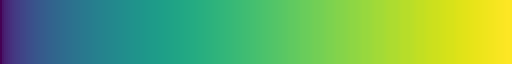

In [13]:
viridisBig = mpl.cm.get_cmap('viridis', 700)

N = 256
n = 2
max_value = 1300

vals1 = np.ones((N, 4))
vals1[:, 0] = np.interp(np.power(np.linspace(0,1,256),1/n), np.linspace(0,1,256), viridisBig(np.linspace(0,1,256))[:,0])
vals1[:, 1] = np.interp(np.power(np.linspace(0,1,256),1/n), np.linspace(0,1,256), viridisBig(np.linspace(0,1,256))[:,1])
vals1[:, 2] = np.interp(np.power(np.linspace(0,1,256),1/n), np.linspace(0,1,256), viridisBig(np.linspace(0,1,256))[:,2])
new_cmap = ListedColormap(vals1)

new_cmap

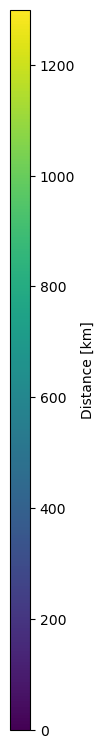

In [14]:
# Create a tall and narrow figure
fig = plt.figure(figsize=(1, 8))  # width, height in inches

# Add a thin and tall axis for the colorbar
cax = fig.add_axes([0.4, 0.05, 0.2, 0.9])  # [left, bottom, width, height]

# Normalize and create the colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=max_value)
cb = mpl.colorbar.ColorbarBase(cax, cmap='viridis', norm=norm, orientation='vertical')

# Customize labels and ticks
cb.set_label('Distance [km]', fontsize=10)
cb.ax.tick_params(labelsize=10)

# plt.savefig(path_to_save_fig + 'isolines_plots/colorbar.png', bbox_inches='tight')

# Contour plots

## 2050 - 2065

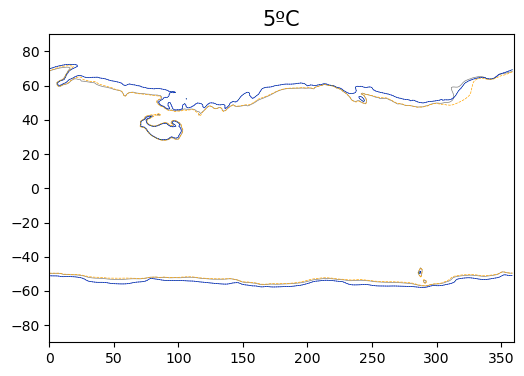

In [15]:
T5_2050 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                            T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                            T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                            T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                            5, '5ºC')

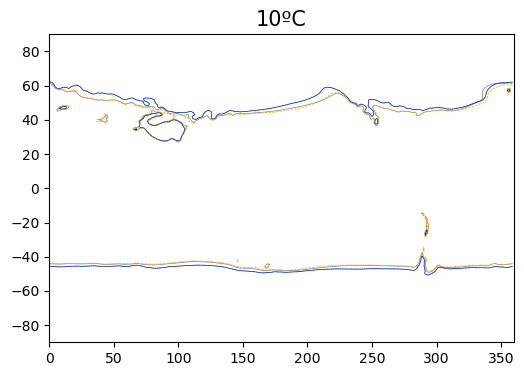

In [16]:
T10_2050 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                             10, '10ºC')

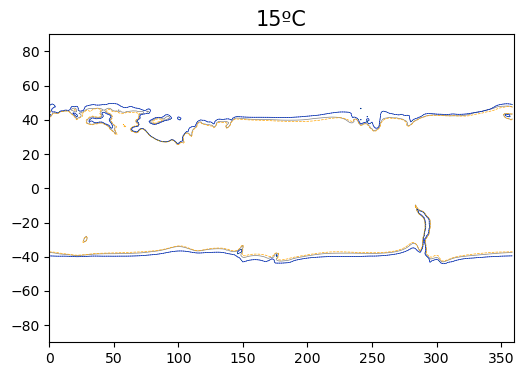

In [17]:
T15_2050 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                             15, '15ºC')

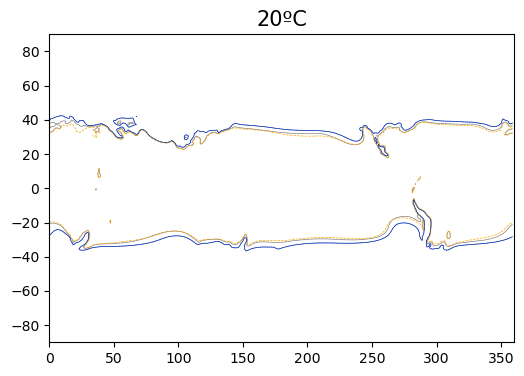

In [18]:
T20_2050 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                             20, '20ºC')

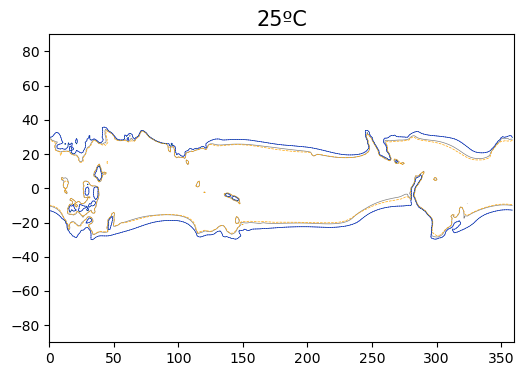

In [19]:
T25_2050 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(30, 45)).mean(dim = 'year'),
                             T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                             25, '25ºC')

## 2085 - 2100

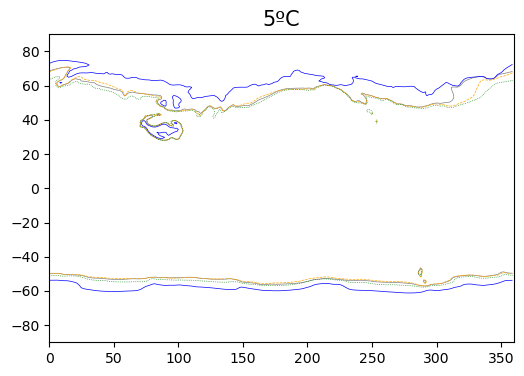

In [20]:
T5_2085 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                            T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                            T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                            T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                            5, '5ºC')

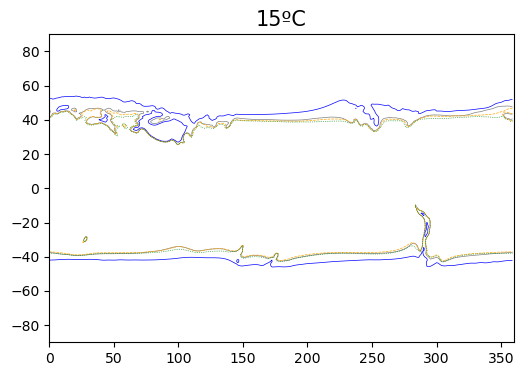

In [21]:
T15_2085 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                             15, '15ºC')

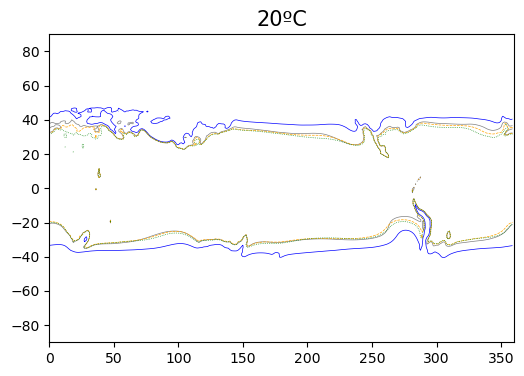

In [22]:
T20_2085 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                             20, '20ºC')

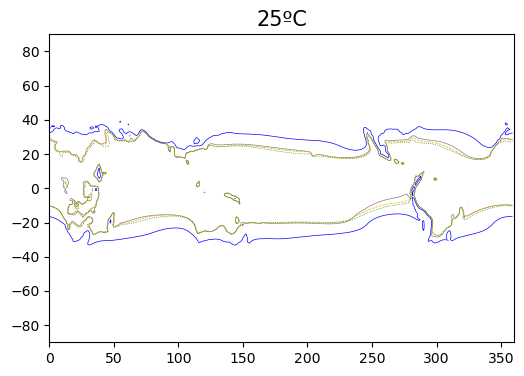

In [23]:
T25_2085 = contour_plots_new(T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['SAI 2020'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['SAI 2080'].groupby('time.year').mean(dim = 'time').isel(year = slice(65, 80)).mean(dim = 'year'),
                             T['Control'].groupby('time.year').mean(dim = 'time').isel(year = slice(0, 15)).mean(dim = 'year'),
                             25, '25ºC')

(0.0, 360.0)

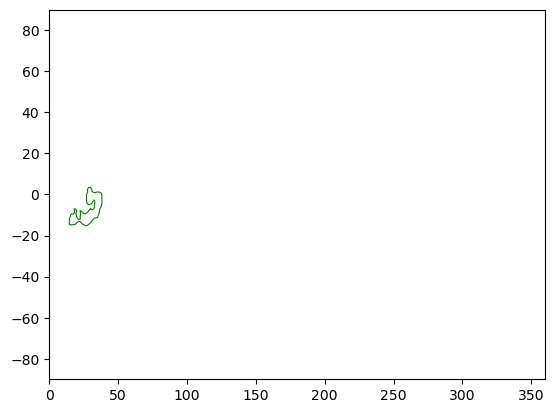

In [24]:
# the contour lines in the plots above have to be found manually by trial-and-error

plt.plot(get_coords(T25_2085[3], 3)[0], get_coords(T25_2085[3], 3)[1], linewidth = 0.8, color = 'green')

plt.ylim(-90, 90)
plt.xlim(0, 360)

# Isolines

## Reference

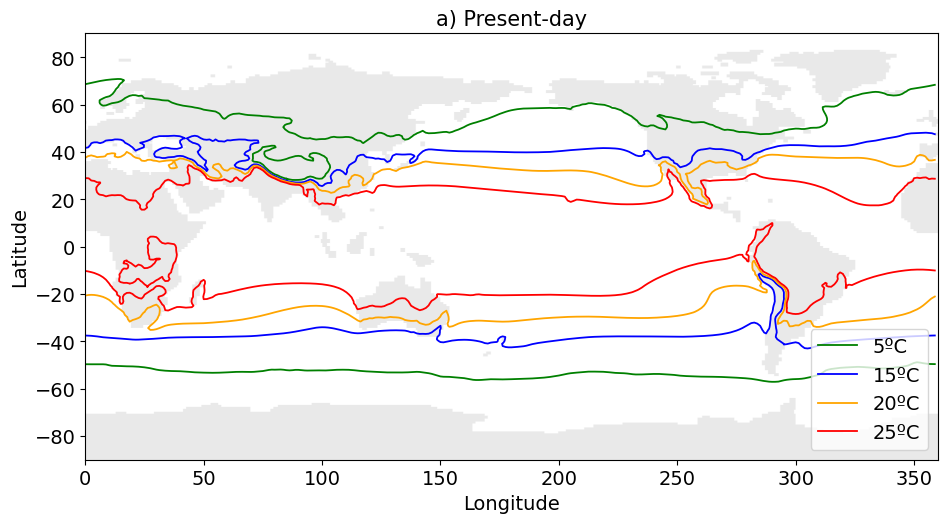

In [25]:
fig = plt.figure(figsize = (11, 12))
ax = plt.gca()

# draw reference isolines
# 5ºC
plt.plot(get_coords(T5_2050[0], 0)[0], get_coords(T5_2050[0], 0)[1], linewidth = 1.3, color = 'green', label = '5ºC')
plt.plot(get_coords(T5_2050[0], 1)[0], get_coords(T5_2050[0], 1)[1], linewidth = 1.3, color = 'green')
plt.plot(get_coords(T5_2050[0], 4)[0], get_coords(T5_2050[0], 4)[1], linewidth = 1.3, color = 'green')

# 15ºC
plt.plot(get_coords(T15_2050[0], 0)[0], get_coords(T15_2050[0], 0)[1], linewidth = 1.3, color = 'blue', label = '15ºC')
plt.plot(get_coords(T15_2050[0], 3)[0], get_coords(T15_2050[0], 3)[1], linewidth = 1.3, color = 'blue')

# 20ºC
plt.plot(get_coords(T20_2050[0], 0)[0], get_coords(T20_2050[0], 0)[1], linewidth = 1.3, color = 'orange', label = '20ºC')
plt.plot(get_coords(T20_2050[0], 3)[0], get_coords(T20_2050[0], 3)[1], linewidth = 1.3, color = 'orange')

# 30ºC
plt.plot(get_coords(T25_2050[0], 0)[0], get_coords(T25_2050[0], 0)[1], linewidth = 1.3, color = 'red', label = '25ºC')
plt.plot(get_coords(T25_2050[0], 1)[0], get_coords(T25_2050[0], 1)[1], linewidth = 1.3, color = 'red')
plt.plot(get_coords(T25_2050[0], 4)[0], get_coords(T25_2050[0], 4)[1], linewidth = 1.3, color = 'red')

# set background image
img = plt.imread(path_to_landmask+'land_mask.png')
ax.imshow(img, extent=[0, 360, -90, 90], alpha = 0.2)

# set axis and title
plt.ylim(-90, 90)
plt.xticks(fontsize = 14)
plt.xlim(0, 360)
plt.yticks(fontsize = 14)
plt.ylabel('Latitude', fontsize = 14)
plt.xlabel('Longitude', fontsize = 14)
plt.title('a) Present-day', fontsize = 15)

# add text
plt.legend(loc = 'lower right', fontsize = 14)

# plt.savefig(path_to_save_fig + 'isolines_plots/ref.png')

## 2050 - 2065

### Control

In [26]:
diff_con_T5_sh = distance(np.radians(get_coords(T5_2050[1], 0)[1]), np.radians(get_coords(T5_2050[1], 0)[0]), # control
                          np.radians(get_coords(T5_2050[0], 0)[1]), np.radians(get_coords(T5_2050[0], 0)[0])) # reference

diff_con_T5_nh = distance(np.radians(get_coords(T5_2050[1], 1)[1]), np.radians(get_coords(T5_2050[1], 1)[0]),
                          np.radians(get_coords(T5_2050[0], 1)[1]), np.radians(get_coords(T5_2050[0], 1)[0]))
diff_con_T5_nh1 = distance(np.radians(get_coords(T5_2050[1], 3)[1]), np.radians(get_coords(T5_2050[1], 3)[0]),
                           np.radians(get_coords(T5_2050[0], 4)[1]), np.radians(get_coords(T5_2050[0], 4)[0]))

In [27]:
diff_con_T15_sh = distance(np.radians(get_coords(T15_2050[1], 0)[1]), np.radians(get_coords(T15_2050[1], 0)[0]), # control
                           np.radians(get_coords(T15_2050[0], 0)[1]), np.radians(get_coords(T15_2050[0], 0)[0])) # reference

diff_con_T15_nh = distance(np.radians(get_coords(T15_2050[1], 2)[1]), np.radians(get_coords(T15_2050[1], 2)[0]),
                           np.radians(get_coords(T15_2050[0], 3)[1]), np.radians(get_coords(T15_2050[0], 3)[0])) 

In [28]:
diff_con_T20_sh = distance(np.radians(get_coords(T20_2050[1], 0)[1]), np.radians(get_coords(T20_2050[1], 0)[0]), # control
                           np.radians(get_coords(T20_2050[0], 0)[1]), np.radians(get_coords(T20_2050[0], 0)[0])) # reference

diff_con_T20_nh = distance(np.radians(get_coords(T20_2050[1], 1)[1]), np.radians(get_coords(T20_2050[1], 1)[0]),
                           np.radians(get_coords(T20_2050[0], 3)[1]), np.radians(get_coords(T20_2050[0], 3)[0])) 

In [29]:
diff_con_T25_sh = distance(np.radians(get_coords(T25_2050[1], 0)[1]), np.radians(get_coords(T25_2050[1], 0)[0]), # control
                           np.radians(get_coords(T25_2050[0], 0)[1]), np.radians(get_coords(T25_2050[0], 0)[0])) # reference

diff_con_T25_nh = distance(np.radians(get_coords(T25_2050[1], 1)[1]), np.radians(get_coords(T25_2050[1], 1)[0]),
                           np.radians(get_coords(T25_2050[0], 1)[1]), np.radians(get_coords(T25_2050[0], 1)[0])) 

In [30]:
x_array_T_c = np.array([get_coords(T5_2050[1], 0)[0], get_coords(T5_2050[1], 1)[0], get_coords(T5_2050[1], 3)[0],
                        get_coords(T15_2050[1], 0)[0], get_coords(T15_2050[1], 2)[0],
                        get_coords(T20_2050[1], 0)[0], get_coords(T20_2050[1], 1)[0],
                        get_coords(T25_2050[1], 0)[0], get_coords(T25_2050[1], 1)[0]], dtype=object)

y_array_T_c = np.array([get_coords(T5_2050[1], 0)[1], get_coords(T5_2050[1], 1)[1], get_coords(T5_2050[1], 3)[1],
                        get_coords(T15_2050[1], 0)[1], get_coords(T15_2050[1], 2)[1],
                        get_coords(T20_2050[1], 0)[1], get_coords(T20_2050[1], 1)[1],
                        get_coords(T25_2050[1], 0)[1], get_coords(T25_2050[1], 1)[1]], dtype=object)

z_array_T_c = np.concatenate((diff_con_T5_sh, diff_con_T5_nh, diff_con_T5_nh1,
                              diff_con_T15_sh, diff_con_T15_nh,
                              diff_con_T20_sh, diff_con_T20_nh,
                              diff_con_T25_sh, diff_con_T25_nh))

Text(330, 20, '25')

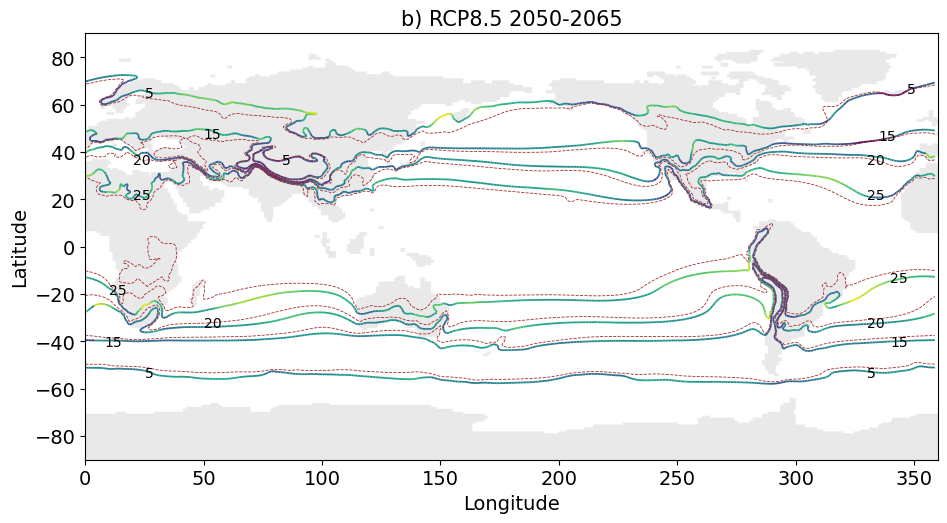

In [31]:
fig = plt.figure(figsize = (11, 12))
ax = plt.gca()
fig.subplots_adjust()

# draw 'control' isolines color-coded based on the difference between 
# their positions in 'control' and their positions in the reference period
colorline_array(ax, x_array_T_c, y_array_T_c, new_cmap, np.clip(z_array_T_c / max_value, 0.0, 1.0), linewidth = 1.3)

# set background image
img = plt.imread(path_to_landmask+'land_mask.png')
ax.imshow(img, extent=[0, 360, -90, 90], alpha = 0.2)

# draw reference isolines
# 5ºC
ax.plot(get_coords(T5_2050[0], 0)[0], get_coords(T5_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 1)[0], get_coords(T5_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 4)[0], get_coords(T5_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 15ºC
ax.plot(get_coords(T15_2050[0], 0)[0], get_coords(T15_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T15_2050[0], 3)[0], get_coords(T15_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 20ºC
ax.plot(get_coords(T20_2050[0], 0)[0], get_coords(T20_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T20_2050[0], 3)[0], get_coords(T20_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 30ºC
ax.plot(get_coords(T25_2050[0], 0)[0], get_coords(T25_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 1)[0], get_coords(T25_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 4)[0], get_coords(T25_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# set axis and title
ax.set_ylabel('Latitude', fontsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.set_xlabel('Longitude', fontsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.set_title('b) RCP8.5 2050-2065', fontsize = 15)

# add text
# 5ºC
ax.text(25, -55, '5', fontsize = 10)
ax.text(330, -55, '5', fontsize = 10)

ax.text(25, 63, '5', fontsize = 10)
ax.text(347, 65, '5', fontsize = 10)

ax.text(83, 35, '5', fontsize = 10)

# 15ºC
ax.text(8, -42, '15', fontsize = 10)
ax.text(340, -42, '15', fontsize = 10)

ax.text(50, 46, '15', fontsize = 10)
ax.text(335, 45, '15', fontsize = 10)

# 20ºC
ax.text(50, -34, '20', fontsize = 10)
ax.text(330, -34, '20', fontsize = 10)

ax.text(20, 35, '20', fontsize = 10)
ax.text(330, 35, '20', fontsize = 10)

# 25ºC
ax.text(10, -20, '25', fontsize = 10)
ax.text(340, -15, '25', fontsize = 10)

ax.text(20, 20, '25', fontsize = 10)
ax.text(330, 20, '25', fontsize = 10)

# plt.savefig(path_to_save_fig + 'isolines_plots/control2050.png')

### SAI 2020

In [32]:
diff_sai20_T5_sh = distance(np.radians(get_coords(T5_2050[2], 0)[1]), np.radians(get_coords(T5_2050[2], 0)[0]), # SAI 2020
                            np.radians(get_coords(T5_2050[0], 0)[1]), np.radians(get_coords(T5_2050[0], 0)[0])) # reference

diff_sai20_T5_nh = distance(np.radians(get_coords(T5_2050[2], 1)[1]), np.radians(get_coords(T5_2050[2], 1)[0]), 
                            np.radians(get_coords(T5_2050[0], 1)[1]), np.radians(get_coords(T5_2050[0], 1)[0]))
diff_sai20_T5_nh1 = distance(np.radians(get_coords(T5_2050[2], 4)[1]), np.radians(get_coords(T5_2050[2], 4)[0]), 
                             np.radians(get_coords(T5_2050[0], 4)[1]), np.radians(get_coords(T5_2050[0], 4)[0]))

In [33]:
diff_sai20_T15_sh = distance(np.radians(get_coords(T15_2050[2], 0)[1]), np.radians(get_coords(T15_2050[2], 0)[0]), # SAI 2020
                             np.radians(get_coords(T15_2050[0], 0)[1]), np.radians(get_coords(T15_2050[0], 0)[0])) # reference

diff_sai20_T15_nh = distance(np.radians(get_coords(T15_2050[2], 3)[1]), np.radians(get_coords(T15_2050[2], 3)[0]), 
                             np.radians(get_coords(T15_2050[0], 3)[1]), np.radians(get_coords(T15_2050[0], 3)[0]))

In [34]:
diff_sai20_T20_sh = distance(np.radians(get_coords(T20_2050[2], 0)[1]), np.radians(get_coords(T20_2050[2], 0)[0]), # SAI 2020
                             np.radians(get_coords(T20_2050[0], 0)[1]), np.radians(get_coords(T20_2050[0], 0)[0])) # reference

diff_sai20_T20_nh = distance(np.radians(get_coords(T20_2050[2], 3)[1]), np.radians(get_coords(T20_2050[2], 3)[0]), 
                             np.radians(get_coords(T20_2050[0], 3)[1]), np.radians(get_coords(T20_2050[0], 3)[0]))

In [35]:
diff_sai20_T25_sh = distance(np.radians(get_coords(T25_2050[2], 0)[1]), np.radians(get_coords(T25_2050[2], 0)[0]), # SAI 2020
                             np.radians(get_coords(T25_2050[0], 0)[1]), np.radians(get_coords(T25_2050[0], 0)[0])) # reference
diff_sai20_T25_sh1 = distance(np.radians(get_coords(T25_2050[2], 4)[1]), np.radians(get_coords(T25_2050[2], 4)[0]), # SAI 2020
                              np.radians(get_coords(T25_2050[0], 4)[1]), np.radians(get_coords(T25_2050[0], 4)[0])) # reference

diff_sai20_T25_nh = distance(np.radians(get_coords(T25_2050[2], 1)[1]), np.radians(get_coords(T25_2050[2], 1)[0]), 
                             np.radians(get_coords(T25_2050[0], 1)[1]), np.radians(get_coords(T25_2050[0], 1)[0]))

In [36]:
x_array_T_sai20 = np.array([get_coords(T5_2050[2], 0)[0], get_coords(T5_2050[2], 1)[0], get_coords(T5_2050[2], 4)[0],
                            get_coords(T15_2050[2], 0)[0], get_coords(T15_2050[2], 3)[0],
                            get_coords(T20_2050[2], 0)[0], get_coords(T20_2050[2], 3)[0],
                            get_coords(T25_2050[2], 0)[0], get_coords(T25_2050[2], 4)[0], get_coords(T25_2050[2], 1)[0]],
                          dtype=object)

y_array_T_sai20 = np.array([get_coords(T5_2050[2], 0)[1], get_coords(T5_2050[2], 1)[1], get_coords(T5_2050[2], 4)[1],
                            get_coords(T15_2050[2], 0)[1], get_coords(T15_2050[2], 3)[1],
                            get_coords(T20_2050[2], 0)[1], get_coords(T20_2050[2], 3)[1],
                            get_coords(T25_2050[2], 0)[1], get_coords(T25_2050[2], 4)[1], get_coords(T25_2050[2], 1)[1]],
                          dtype=object)

z_array_T_sai20 = np.concatenate((diff_sai20_T5_sh, diff_sai20_T5_nh, diff_sai20_T5_nh1,
                                  diff_sai20_T15_sh, diff_sai20_T15_nh,
                                  diff_sai20_T20_sh, diff_sai20_T20_nh,
                                  diff_sai20_T25_sh, diff_sai20_T25_sh1, diff_sai20_T25_nh))

Text(35, 0, '25')

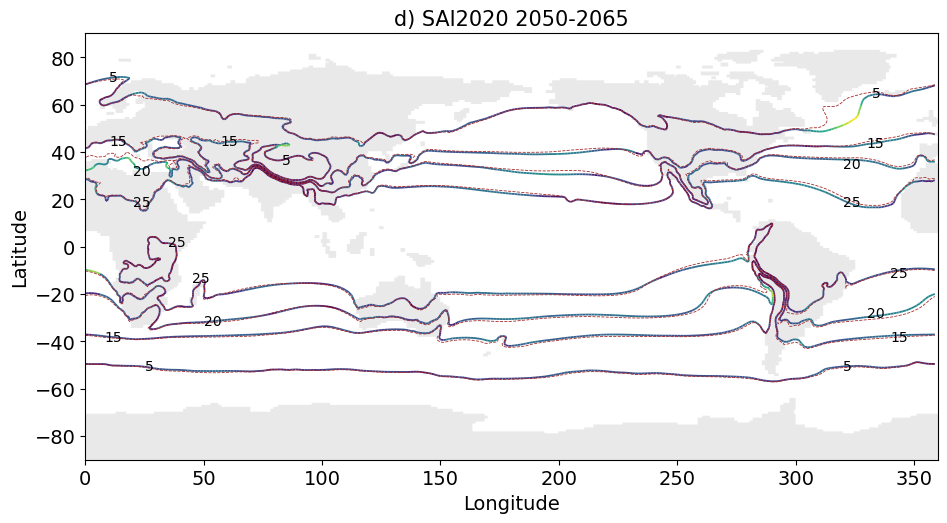

In [37]:
fig = plt.figure(figsize = (11, 12))
ax = plt.gca()
fig.subplots_adjust()

# draw 'SAI2020' isolines color-coded based on the difference between 
# their positions in 'SAI2020' and their positions in the reference period
colorline_array(ax, x_array_T_sai20, y_array_T_sai20, new_cmap, np.clip(z_array_T_sai20 / max_value, 0.0, 1.0), linewidth = 1.3)

# draw reference isolines
# 5ºC
ax.plot(get_coords(T5_2050[0], 0)[0], get_coords(T5_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 1)[0], get_coords(T5_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 4)[0], get_coords(T5_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 15ºC
ax.plot(get_coords(T15_2050[0], 0)[0], get_coords(T15_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T15_2050[0], 3)[0], get_coords(T15_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 20ºC
ax.plot(get_coords(T20_2050[0], 0)[0], get_coords(T20_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T20_2050[0], 3)[0], get_coords(T20_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 30ºC
ax.plot(get_coords(T25_2050[0], 0)[0], get_coords(T25_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 1)[0], get_coords(T25_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 4)[0], get_coords(T25_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# set background image
img = plt.imread(path_to_landmask+'land_mask.png')
ax.imshow(img, extent=[0, 360, -90, 90], alpha = 0.2)

# set axis and title
ax.set_ylabel('Latitude', fontsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.set_xlabel('Longitude', fontsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.set_title('d) SAI2020 2050-2065', fontsize = 15)

# add text
# 5ºC
ax.text(25, -52, '5', fontsize = 10)
ax.text(320, -52, '5', fontsize = 10)

ax.text(10, 70, '5', fontsize = 10)
ax.text(332, 63, '5', fontsize = 10)

ax.text(83, 35, '5', fontsize = 10)

# 15ºC
ax.text(8, -40, '15', fontsize = 10)
ax.text(340, -40, '15', fontsize = 10)

ax.text(57, 43, '15', fontsize = 10)

ax.text(10, 43, '15', fontsize = 10)
ax.text(330, 42, '15', fontsize = 10)

# 20ºC
ax.text(50, -33, '20', fontsize = 10)
ax.text(330, -30, '20', fontsize = 10)

ax.text(20, 30, '20', fontsize = 10)
ax.text(320, 33, '20', fontsize = 10)

# 25ºC
ax.text(45, -15, '25', fontsize = 10)
ax.text(340, -13, '25', fontsize = 10)

ax.text(20, 17, '25', fontsize = 10)
ax.text(320, 17, '25', fontsize = 10)

ax.text(35, 0, '25', fontsize = 10)

# plt.savefig(path_to_save_fig + 'isolines_plots/sai2020_2050.png')

## 2085 - 2100

### Control

In [38]:
diff_con85_T5_sh = distance(np.radians(get_coords(T5_2085[1], 0)[1]), np.radians(get_coords(T5_2085[1], 0)[0]), # control
                            np.radians(get_coords(T5_2085[0], 0)[1]), np.radians(get_coords(T5_2085[0], 0)[0])) # reference

diff_con85_T5_nh = distance(np.radians(get_coords(T5_2085[1], 1)[1]), np.radians(get_coords(T5_2085[1], 1)[0]),
                            np.radians(get_coords(T5_2085[0], 1)[1]), np.radians(get_coords(T5_2085[0], 1)[0]))
diff_con85_T5_nh1 = distance(np.radians(get_coords(T5_2085[1], 2)[1]), np.radians(get_coords(T5_2085[1], 2)[0]),
                             np.radians(get_coords(T5_2085[0], 4)[1]), np.radians(get_coords(T5_2085[0], 4)[0]))

In [39]:
diff_con85_T15_sh = distance(np.radians(get_coords(T15_2085[1], 0)[1]), np.radians(get_coords(T15_2085[1], 0)[0]), # control
                             np.radians(get_coords(T15_2085[0], 0)[1]), np.radians(get_coords(T15_2085[0], 0)[0])) # reference

diff_con85_T15_nh = distance(np.radians(get_coords(T15_2085[1], 1)[1]), np.radians(get_coords(T15_2085[1], 1)[0]),
                             np.radians(get_coords(T15_2085[0], 3)[1]), np.radians(get_coords(T15_2085[0], 3)[0]))
diff_con85_T15_nh1 = distance(np.radians(get_coords(T15_2085[1], 7)[1]), np.radians(get_coords(T15_2085[1], 7)[0]),
                              np.radians(get_coords(T15_2085[0], 3)[1]), np.radians(get_coords(T15_2085[0], 3)[0]))

In [40]:
diff_con85_T20_sh = distance(np.radians(get_coords(T20_2085[1], 0)[1]), np.radians(get_coords(T20_2085[1], 0)[0]), # control
                             np.radians(get_coords(T20_2085[0], 0)[1]), np.radians(get_coords(T20_2085[0], 0)[0])) # reference

diff_con85_T20_nh = distance(np.radians(get_coords(T20_2085[1], 1)[1]), np.radians(get_coords(T20_2085[1], 1)[0]),
                             np.radians(get_coords(T20_2085[0], 3)[1]), np.radians(get_coords(T20_2085[0], 3)[0]))
diff_con85_T20_nh1 = distance(np.radians(get_coords(T20_2085[1], 4)[1]), np.radians(get_coords(T20_2085[1], 4)[0]),
                              np.radians(get_coords(T20_2085[0], 3)[1]), np.radians(get_coords(T20_2085[0], 3)[0]))

In [41]:
diff_con85_T25_sh = distance(np.radians(get_coords(T25_2085[1], 0)[1]), np.radians(get_coords(T25_2085[1], 0)[0]), # control
                             np.radians(get_coords(T25_2085[0], 0)[1]), np.radians(get_coords(T25_2085[0], 0)[0])) # reference

diff_con85_T25_nh = distance(np.radians(get_coords(T25_2085[1], 1)[1]), np.radians(get_coords(T25_2085[1], 1)[0]),
                             np.radians(get_coords(T25_2085[0], 1)[1]), np.radians(get_coords(T25_2085[0], 1)[0]))

In [42]:
x_array_T_c85 = np.array([get_coords(T5_2085[1], 0)[0], get_coords(T5_2085[1], 1)[0], get_coords(T5_2085[1], 2)[0],
                          get_coords(T15_2085[1], 0)[0], get_coords(T15_2085[1], 1)[0], get_coords(T15_2085[1], 7)[0],
                          get_coords(T20_2085[1], 0)[0], get_coords(T20_2085[1], 1)[0], get_coords(T20_2085[1], 4)[0],
                          get_coords(T25_2085[1], 0)[0], get_coords(T25_2085[1], 1)[0]], dtype=object)

y_array_T_c85 = np.array([get_coords(T5_2085[1], 0)[1], get_coords(T5_2085[1], 1)[1], get_coords(T5_2085[1], 2)[1],
                          get_coords(T15_2085[1], 0)[1], get_coords(T15_2085[1], 1)[1], get_coords(T15_2085[1], 7)[1],
                          get_coords(T20_2085[1], 0)[1], get_coords(T20_2085[1], 1)[1], get_coords(T20_2085[1], 4)[1],
                          get_coords(T25_2085[1], 0)[1], get_coords(T25_2085[1], 1)[1]], dtype=object)

z_array_T_c85 = np.concatenate((diff_con85_T5_sh, diff_con85_T5_nh, diff_con85_T5_nh1,
                                diff_con85_T15_sh, diff_con85_T15_nh, diff_con85_T15_nh1,
                                diff_con85_T20_sh, diff_con85_T20_nh, diff_con85_T20_nh1,
                                diff_con85_T25_sh, diff_con85_T25_nh))

Text(330, 24, '25')

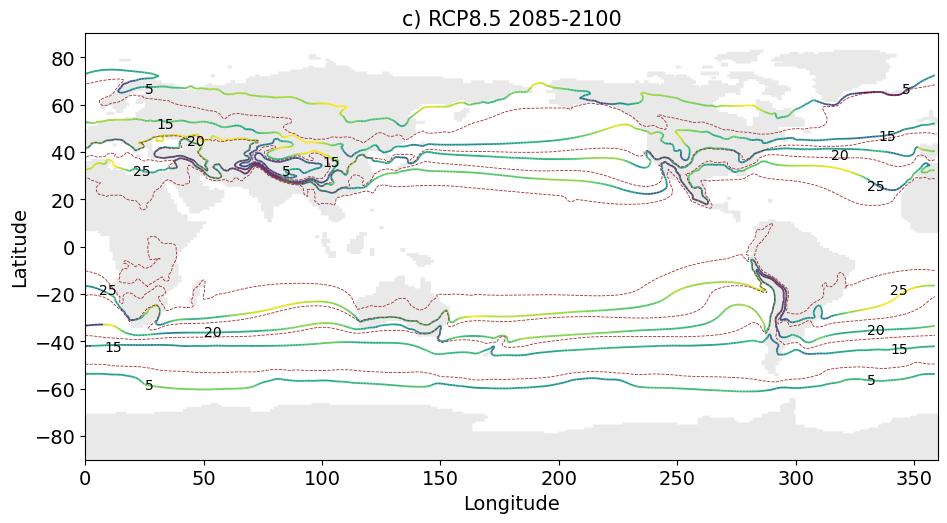

In [43]:
fig = plt.figure(figsize = (11, 12))
ax = plt.gca()
fig.subplots_adjust()

# draw 'control' isolines color-coded based on the difference between 
# their positions in 'control' and their positions in the reference period
colorline_array(ax, x_array_T_c85, y_array_T_c85, new_cmap, np.clip(z_array_T_c85 / max_value, 0.0, 1.0), linewidth = 1.3)

# set background image
img = plt.imread(path_to_landmask+'land_mask.png')
ax.imshow(img, extent=[0, 360, -90, 90], alpha = 0.2)

# draw reference isolines
# 5ºC
ax.plot(get_coords(T5_2050[0], 0)[0], get_coords(T5_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 1)[0], get_coords(T5_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 4)[0], get_coords(T5_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 15ºC
ax.plot(get_coords(T15_2050[0], 0)[0], get_coords(T15_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T15_2050[0], 3)[0], get_coords(T15_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 20ºC
ax.plot(get_coords(T20_2050[0], 0)[0], get_coords(T20_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T20_2050[0], 3)[0], get_coords(T20_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 30ºC
ax.plot(get_coords(T25_2050[0], 0)[0], get_coords(T25_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 1)[0], get_coords(T25_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 4)[0], get_coords(T25_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# set axis and title
ax.set_ylabel('Latitude', fontsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.set_xlabel('Longitude', fontsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.set_title('c) RCP8.5 2085-2100', fontsize = 15)

# add text
# 5ºC
ax.text(25, -60, '5', fontsize = 10)
ax.text(330, -58, '5', fontsize = 10)

ax.text(25, 65, '5', fontsize = 10)
ax.text(345, 65, '5', fontsize = 10)

ax.text(83, 30, '5', fontsize = 10)

# 15ºC
ax.text(8, -44, '15', fontsize = 10)
ax.text(340, -45, '15', fontsize = 10)

ax.text(30, 50, '15', fontsize = 10)
ax.text(335, 45, '15', fontsize = 10)

ax.text(100, 34, '15', fontsize = 10)

# 20ºC
ax.text(50, -38, '20', fontsize = 10)
ax.text(330, -37, '20', fontsize = 10)

ax.text(43, 43, '20', fontsize = 10)
ax.text(315, 37, '20', fontsize = 10)

# 25ºC
ax.text(6, -20, '25', fontsize = 10)
ax.text(340, -20, '25', fontsize = 10)

ax.text(20, 30, '25', fontsize = 10)
ax.text(330, 24, '25', fontsize = 10)

# plt.savefig(path_to_save_fig + 'isolines_plots/control2085.png')

### SAI 2020

In [44]:
diff_sai20_85_T5_sh = distance(np.radians(get_coords(T5_2085[2], 0)[1]), np.radians(get_coords(T5_2085[2], 0)[0]), # SAI 2020
                               np.radians(get_coords(T5_2085[0], 0)[1]), np.radians(get_coords(T5_2085[0], 0)[0])) # reference

diff_sai20_85_T5_nh = distance(np.radians(get_coords(T5_2085[2], 1)[1]), np.radians(get_coords(T5_2085[2], 1)[0]), 
                               np.radians(get_coords(T5_2085[0], 1)[1]), np.radians(get_coords(T5_2085[0], 1)[0]))
diff_sai20_85_T5_nh1 = distance(np.radians(get_coords(T5_2085[2], 4)[1]), np.radians(get_coords(T5_2085[2], 4)[0]), 
                                np.radians(get_coords(T5_2085[0], 4)[1]), np.radians(get_coords(T5_2085[0], 4)[0]))

In [45]:
diff_sai20_85_T15_sh = distance(np.radians(get_coords(T15_2085[2], 0)[1]), np.radians(get_coords(T15_2085[2], 0)[0]), # SAI 2020
                                np.radians(get_coords(T15_2085[0], 0)[1]), np.radians(get_coords(T15_2085[0], 0)[0])) # reference

diff_sai20_85_T15_nh = distance(np.radians(get_coords(T15_2085[2], 3)[1]), np.radians(get_coords(T15_2085[2], 3)[0]), 
                                np.radians(get_coords(T15_2085[0], 3)[1]), np.radians(get_coords(T15_2085[0], 3)[0]))

In [46]:
diff_sai20_85_T20_sh = distance(np.radians(get_coords(T20_2085[2], 0)[1]), np.radians(get_coords(T20_2085[2], 0)[0]), # SAI 2020
                                np.radians(get_coords(T20_2085[0], 0)[1]), np.radians(get_coords(T20_2085[0], 0)[0])) # reference

diff_sai20_85_T20_nh = distance(np.radians(get_coords(T20_2085[2], 1)[1]), np.radians(get_coords(T20_2085[2], 1)[0]), 
                                np.radians(get_coords(T20_2085[0], 3)[1]), np.radians(get_coords(T20_2085[0], 3)[0]))

In [47]:
diff_sai20_85_T25_sh = distance(np.radians(get_coords(T25_2085[2], 0)[1]), np.radians(get_coords(T25_2085[2], 0)[0]), # SAI 2020
                                np.radians(get_coords(T25_2085[0], 0)[1]), np.radians(get_coords(T25_2085[0], 0)[0])) # reference

diff_sai20_85_T25_nh = distance(np.radians(get_coords(T25_2085[2], 1)[1]), np.radians(get_coords(T25_2085[2], 1)[0]), 
                                np.radians(get_coords(T25_2085[0], 1)[1]), np.radians(get_coords(T25_2085[0], 1)[0]))
diff_sai20_85_T25_nh1 = distance(np.radians(get_coords(T25_2085[2], 3)[1]), np.radians(get_coords(T25_2085[2], 3)[0]), 
                                 np.radians(get_coords(T25_2085[0], 4)[1]), np.radians(get_coords(T25_2085[0], 4)[0]))

In [48]:
x_array_T_sai20_85 = np.array([get_coords(T5_2085[2], 0)[0], get_coords(T5_2085[2], 1)[0], get_coords(T5_2085[2], 4)[0],
                               get_coords(T15_2085[2], 0)[0], get_coords(T15_2085[2], 3)[0],
                               get_coords(T20_2085[2], 0)[0], get_coords(T20_2085[2], 1)[0],
                               get_coords(T25_2085[2], 0)[0], get_coords(T25_2085[2], 1)[0], get_coords(T25_2085[2], 3)[0]],
                             dtype = object)

y_array_T_sai20_85 = np.array([get_coords(T5_2085[2], 0)[1], get_coords(T5_2085[2], 1)[1], get_coords(T5_2085[2], 4)[1],
                               get_coords(T15_2085[2], 0)[1], get_coords(T15_2085[2], 3)[1],
                               get_coords(T20_2085[2], 0)[1], get_coords(T20_2085[2], 1)[1],
                               get_coords(T25_2085[2], 0)[1], get_coords(T25_2085[2], 1)[1], get_coords(T25_2085[2], 3)[1]],
                             dtype = object)

z_array_T_sai20_85 = np.concatenate((diff_sai20_85_T5_sh, diff_sai20_85_T5_nh, diff_sai20_85_T5_nh1,
                                     diff_sai20_85_T15_sh, diff_sai20_85_T15_nh,
                                     diff_sai20_85_T20_sh, diff_sai20_85_T20_nh,
                                     diff_sai20_85_T25_sh, diff_sai20_85_T25_nh, diff_sai20_85_T25_nh1))

Text(35, 0, '25')

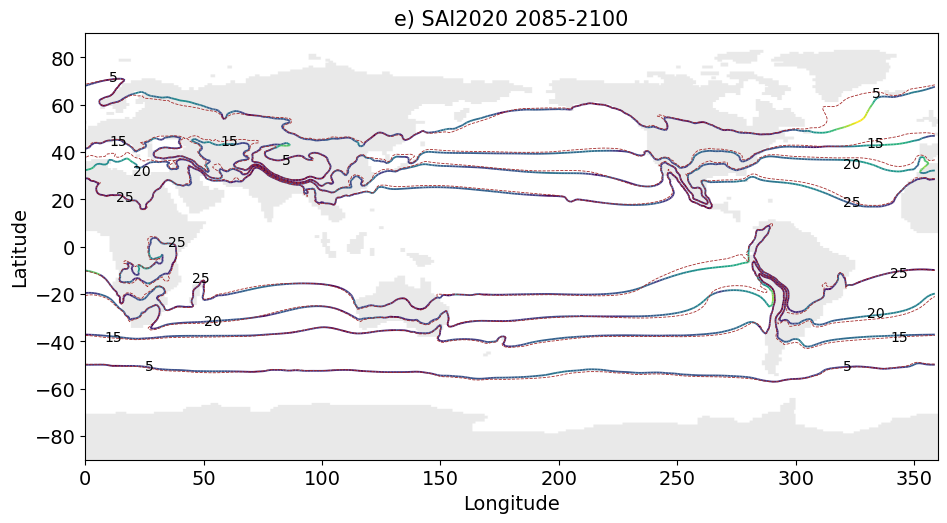

In [49]:
fig = plt.figure(figsize = (11, 12))
ax = plt.gca()
fig.subplots_adjust()

# draw 'SAI2020' isolines color-coded based on the difference between 
# their positions in 'SAI2020' and their positions in the reference period
colorline_array(ax, x_array_T_sai20_85, y_array_T_sai20_85, new_cmap, np.clip(z_array_T_sai20_85 / max_value, 0.0, 1.0), linewidth = 1.3)

# set background image
img = plt.imread(path_to_landmask+'land_mask.png')
ax.imshow(img, extent=[0, 360, -90, 90], alpha = 0.2)

# draw reference isolines
# 5ºC
ax.plot(get_coords(T5_2050[0], 0)[0], get_coords(T5_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 1)[0], get_coords(T5_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 4)[0], get_coords(T5_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 15ºC
ax.plot(get_coords(T15_2050[0], 0)[0], get_coords(T15_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T15_2050[0], 3)[0], get_coords(T15_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 20ºC
ax.plot(get_coords(T20_2050[0], 0)[0], get_coords(T20_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T20_2050[0], 3)[0], get_coords(T20_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 30ºC
ax.plot(get_coords(T25_2050[0], 0)[0], get_coords(T25_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 1)[0], get_coords(T25_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 4)[0], get_coords(T25_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# set axis and title
ax.set_ylabel('Latitude', fontsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.set_xlabel('Longitude', fontsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.set_title('e) SAI2020 2085-2100', fontsize = 15)

# add text
# 5ºC
ax.text(25, -52, '5', fontsize = 10)
ax.text(320, -52, '5', fontsize = 10)

ax.text(10, 70, '5', fontsize = 10)
ax.text(332, 63, '5', fontsize = 10)

ax.text(83, 35, '5', fontsize = 10)

# 15ºC
ax.text(8, -40, '15', fontsize = 10)
ax.text(340, -40, '15', fontsize = 10)

ax.text(57, 43, '15', fontsize = 10)

ax.text(10, 43, '15', fontsize = 10)
ax.text(330, 42, '15', fontsize = 10)

# 20ºC
ax.text(50, -33, '20', fontsize = 10)
ax.text(330, -30, '20', fontsize = 10)

ax.text(20, 30, '20', fontsize = 10)
ax.text(320, 33, '20', fontsize = 10)

# 25ºC
ax.text(45, -15, '25', fontsize = 10)
ax.text(340, -13, '25', fontsize = 10)

ax.text(13, 19, '25', fontsize = 10)
ax.text(320, 17, '25', fontsize = 10)

ax.text(35, 0, '25', fontsize = 10)

# plt.savefig(path_to_save_fig + 'isolines_plots/sai2020_2085.png')

### SAI 2080

In [50]:
diff_sai80_85_T5_sh = distance(np.radians(get_coords(T5_2085[3], 0)[1]), np.radians(get_coords(T5_2085[3], 0)[0]), # SAI 2080
                               np.radians(get_coords(T5_2085[0], 0)[1]), np.radians(get_coords(T5_2085[0], 0)[0])) # reference

diff_sai80_85_T5_nh = distance(np.radians(get_coords(T5_2085[3], 1)[1]), np.radians(get_coords(T5_2085[3], 1)[0]), 
                               np.radians(get_coords(T5_2085[0], 1)[1]), np.radians(get_coords(T5_2085[0], 1)[0]))
diff_sai80_85_T5_nh1 = distance(np.radians(get_coords(T5_2085[3], 3)[1]), np.radians(get_coords(T5_2085[3], 3)[0]), 
                                np.radians(get_coords(T5_2085[0], 4)[1]), np.radians(get_coords(T5_2085[0], 4)[0]))

In [51]:
diff_sai80_85_T15_sh = distance(np.radians(get_coords(T15_2085[3], 0)[1]), np.radians(get_coords(T15_2085[3], 0)[0]), # SAI 2080
                                np.radians(get_coords(T15_2085[0], 0)[1]), np.radians(get_coords(T15_2085[0], 0)[0])) # reference

diff_sai80_85_T15_nh = distance(np.radians(get_coords(T15_2085[3], 1)[1]), np.radians(get_coords(T15_2085[3], 1)[0]), 
                                np.radians(get_coords(T15_2085[0], 3)[1]), np.radians(get_coords(T15_2085[0], 3)[0]))

In [52]:
diff_sai80_85_T20_sh = distance(np.radians(get_coords(T20_2085[3], 0)[1]), np.radians(get_coords(T20_2085[3], 0)[0]), # SAI 2080
                                np.radians(get_coords(T20_2085[0], 0)[1]), np.radians(get_coords(T20_2085[0], 0)[0])) # reference

diff_sai80_85_T20_nh = distance(np.radians(get_coords(T20_2085[3], 1)[1]), np.radians(get_coords(T20_2085[3], 1)[0]), 
                                np.radians(get_coords(T20_2085[0], 3)[1]), np.radians(get_coords(T20_2085[0], 3)[0]))

In [53]:
diff_sai80_85_T25_sh = distance(np.radians(get_coords(T25_2085[3], 0)[1]), np.radians(get_coords(T25_2085[3], 0)[0]), # SAI 2080
                                np.radians(get_coords(T25_2085[0], 0)[1]), np.radians(get_coords(T25_2085[0], 0)[0])) # reference

diff_sai80_85_T25_nh = distance(np.radians(get_coords(T25_2085[3], 1)[1]), np.radians(get_coords(T25_2085[3], 1)[0]), 
                                np.radians(get_coords(T25_2085[0], 1)[1]), np.radians(get_coords(T25_2085[0], 1)[0]))
diff_sai80_85_T25_nh1 = distance(np.radians(get_coords(T25_2085[3], 3)[1]), np.radians(get_coords(T25_2085[3], 3)[0]), 
                                 np.radians(get_coords(T25_2085[0], 4)[1]), np.radians(get_coords(T25_2085[0], 4)[0]))

In [54]:
x_array_T_sai80_85 = np.array([get_coords(T5_2085[3], 0)[0], get_coords(T5_2085[3], 1)[0], get_coords(T5_2085[3], 3)[0],
                               get_coords(T15_2085[3], 0)[0], get_coords(T15_2085[3], 1)[0],
                               get_coords(T20_2085[3], 0)[0], get_coords(T20_2085[3], 1)[0],
                               get_coords(T25_2085[3], 0)[0], get_coords(T25_2085[3], 1)[0], get_coords(T25_2085[3], 3)[0]],
                             dtype=object)

y_array_T_sai80_85 = np.array([get_coords(T5_2085[3], 0)[1], get_coords(T5_2085[3], 1)[1], get_coords(T5_2085[3], 3)[1],
                               get_coords(T15_2085[3], 0)[1], get_coords(T15_2085[3], 1)[1],
                               get_coords(T20_2085[3], 0)[1], get_coords(T20_2085[3], 1)[1],
                               get_coords(T25_2085[3], 0)[1], get_coords(T25_2085[3], 1)[1], get_coords(T25_2085[3], 3)[1]],
                             dtype=object)

z_array_T_sai80_85 = np.concatenate((diff_sai80_85_T5_sh, diff_sai80_85_T5_nh, diff_sai80_85_T5_nh1,
                                     diff_sai80_85_T15_sh, diff_sai80_85_T15_nh,
                                     diff_sai80_85_T20_sh, diff_sai80_85_T20_nh,
                                     diff_sai80_85_T25_sh, diff_sai80_85_T25_nh, diff_sai80_85_T25_nh1))

Text(35, 0, '25')

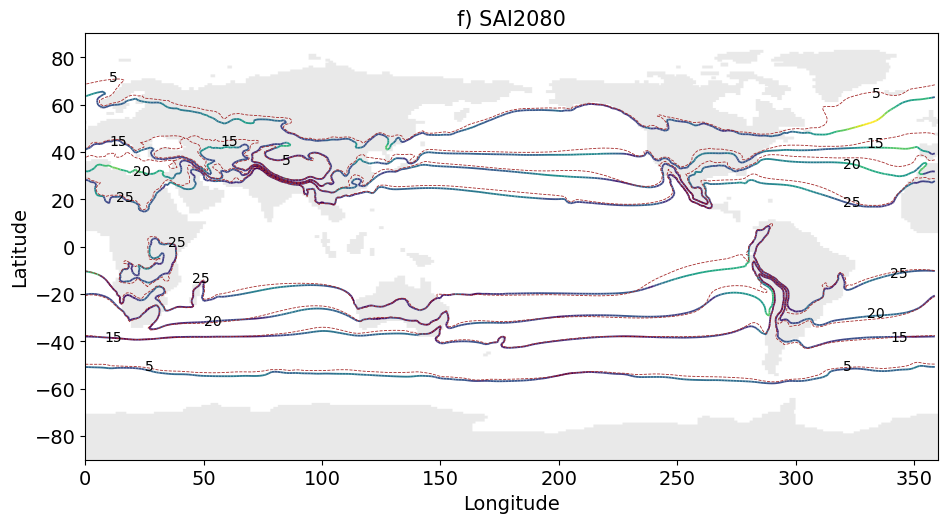

In [55]:
fig = plt.figure(figsize = (11, 12))
ax = plt.gca()
fig.subplots_adjust()

# draw 'SAI2080' isolines color-coded based on the difference between 
# their positions in 'SAI2080' and their positions in the reference period
colorline_array(ax, x_array_T_sai80_85, y_array_T_sai80_85, new_cmap, np.clip(z_array_T_sai80_85 / max_value, 0.0, 1.0), linewidth = 1.3)

# set background image
img = plt.imread(path_to_landmask+'land_mask.png')
ax.imshow(img, extent=[0, 360, -90, 90], alpha = 0.2)

# draw reference isolines
# 5ºC
ax.plot(get_coords(T5_2050[0], 0)[0], get_coords(T5_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 1)[0], get_coords(T5_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T5_2050[0], 4)[0], get_coords(T5_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 15ºC
ax.plot(get_coords(T15_2050[0], 0)[0], get_coords(T15_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T15_2050[0], 3)[0], get_coords(T15_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 20ºC
ax.plot(get_coords(T20_2050[0], 0)[0], get_coords(T20_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T20_2050[0], 3)[0], get_coords(T20_2050[0], 3)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# 30ºC
ax.plot(get_coords(T25_2050[0], 0)[0], get_coords(T25_2050[0], 0)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 1)[0], get_coords(T25_2050[0], 1)[1], color = 'brown', linestyle='dashed', linewidth=0.6)
ax.plot(get_coords(T25_2050[0], 4)[0], get_coords(T25_2050[0], 4)[1], color = 'brown', linestyle='dashed', linewidth=0.6)

# set axis and title
ax.set_ylabel('Latitude', fontsize = 14)
ax.yaxis.set_tick_params(labelsize = 14)
ax.set_xlabel('Longitude', fontsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
ax.set_title('f) SAI2080', fontsize = 15)

# add text
# 5ºC
ax.text(25, -52, '5', fontsize = 10)
ax.text(320, -52, '5', fontsize = 10)

ax.text(10, 70, '5', fontsize = 10)
ax.text(332, 63, '5', fontsize = 10)

ax.text(83, 35, '5', fontsize = 10)

# 15ºC
ax.text(8, -40, '15', fontsize = 10)
ax.text(340, -40, '15', fontsize = 10)

ax.text(57, 43, '15', fontsize = 10)

ax.text(10, 43, '15', fontsize = 10)
ax.text(330, 42, '15', fontsize = 10)

# 20ºC
ax.text(50, -33, '20', fontsize = 10)
ax.text(330, -30, '20', fontsize = 10)

ax.text(20, 30, '20', fontsize = 10)
ax.text(320, 33, '20', fontsize = 10)

# 25ºC
ax.text(45, -15, '25', fontsize = 10)
ax.text(340, -13, '25', fontsize = 10)

ax.text(13, 19, '25', fontsize = 10)
ax.text(320, 17, '25', fontsize = 10)

ax.text(35, 0, '25', fontsize = 10)

# plt.savefig(path_to_save_fig + 'isolines_plots/sai2080_2085.png')